In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm, shapiro
import math
from scipy import stats
from scipy.stats import shapiro 
from scipy.stats import norm, t

# Data Import & Processing

Import the data

In [95]:
# Price, Return, Momentum, Trend
df_ETF = pd.read_csv('ACWI_Prices.xlsx - ACWI.csv', skiprows=4)

# Value
df_P2E    = pd.read_excel('ACWI_Valuation.xlsx',sheet_name='PE', skiprows=7)
df_P2B    = pd.read_excel('ACWI_Valuation.xlsx',sheet_name='Book_value', skiprows=7)
df_P2CF   = pd.read_excel('ACWI_Valuation.xlsx',sheet_name='Cash_Flow', skiprows=7)
df_P2EBTA = pd.read_excel('ACWI_Valuation.xlsx',sheet_name='P_sales', skiprows=7)

# Quality
df_ROE_Sheet1 = pd.read_excel('ACWI_Quality.xlsx',sheet_name='Data1', skiprows=8).drop(1)
df_ROE_Sheet2 = pd.read_excel('ACWI_Quality.xlsx',sheet_name='Data2', skiprows=8).drop(1)


df_D2E    = pd.read_excel('ACWI_Valuation.xlsx',sheet_name='NDEV', skiprows=4)
df_T12MPM = pd.read_excel('ACWI_Valuation.xlsx',sheet_name='MARG', skiprows=4)


## Data Cleaning for value data

In [96]:
ETF_names = df_P2E.iloc[0, :]
df_P2E.columns = ETF_names
df_P2E_process = df_P2E.drop(0, axis = 0)
df_P2E_process['Date'] = pd.to_datetime(df_P2E_process['Date'], format='%Y/%m/%d')
df_P2E_process.index = df_P2E_process['Date']
df_P2E_process2 = df_P2E_process.drop('Date', axis = 1)

ETF_names = df_P2B.iloc[0, :]
df_P2B.columns = ETF_names
df_P2B_process = df_P2B.drop(0, axis = 0)
# df_P2B_process['Date'] = pd.to_datetime(df_P2B_process['Date'], format='%m/%d/%Y')
df_P2B_process['Date'] = pd.to_datetime(df_P2B_process['Date'], format='%Y/%m/%d')
df_P2B_process.index = df_P2B_process['Date']
df_P2B_process2 = df_P2B_process.drop('Date', axis = 1)

ETF_names = df_P2CF.iloc[0, :]
df_P2CF.columns = ETF_names
df_P2CF_process = df_P2CF.drop(0, axis = 0)
df_P2CF_process['Date'] = pd.to_datetime(df_P2CF_process['Date'], format='%Y/%m/%d')
df_P2CF_process.index = df_P2CF_process['Date']
df_P2CF_process2 = df_P2CF_process.drop('Date', axis = 1)

ETF_names = df_P2EBTA.iloc[0, :]
df_P2EBTA.columns = ETF_names
df_P2EBTA_process = df_P2EBTA.drop(0, axis = 0)
df_P2EBTA_process['Date'] = pd.to_datetime(df_P2EBTA_process['Date'], format='%Y/%m/%d')
df_P2EBTA_process.index = df_P2EBTA_process['Date']
df_P2EBTA_process2 = df_P2EBTA_process.drop('Date', axis = 1)

#df_P2E_process2.shape
#df_P2B_process2.shape
#df_P2CF_process2.shape
#df_P2EBTA_process2.shape


Check the missing values

In [97]:
na_counts_P2E = df_P2E_process2.isna().sum()
sorted_na_counts_P2E = na_counts_P2E.sort_values(ascending=False)
print(sorted_na_counts_P2E)
# LUXXX(No Data), HSCEI(2013/03/29), COLCAP(after 2009/03/31)


na_counts_P2B = df_P2B_process2.isna().sum()
sorted_na_counts_P2B = na_counts_P2B.sort_values(ascending=False)
print(sorted_na_counts_P2B)
# LUXXX(No Data), HSCEI(2013/03/29), COLCAP(after 2009/06/30)

na_counts_P2CF = df_P2CF_process2.isna().sum()
sorted_na_counts_P2CF = na_counts_P2CF.sort_values(ascending=False)
print(sorted_na_counts_P2CF)
# LUXXX(No Data), HSCEI(2013/03/29), COLCAP(after 2010/06/30)

na_counts_P2EBTA = df_P2EBTA_process2.isna().sum()
sorted_na_counts_P2EBTA = na_counts_P2EBTA.sort_values(ascending=False)
print(sorted_na_counts_P2EBTA)
# DSM, MXAU, MXMY, LUXXX, SIMSCI, HSCEI, MXES, MXTR, MXIT(Barely have no data)
# COLCAP(after 2012/06/29)

0
LUXXX Index      386
HSCEI Index      266
COLCAP Index     218
TWSE Index       194
IPSA Index       192
DSM Index        180
SHSZ300 Index    180
MXAED Index      176
INDEXCF Index    159
NKY Index        159
MXIN Index       148
KOSPI Index      146
UKX Index        137
MEXBOL Index     134
DAX Index        134
SET Index        133
OBX Index        132
BUX Index        132
MXAU Index       126
MXAT Index       126
SPTSX Index      126
OMX Index        123
MXEG Index       121
MXCZ Index       121
MXZA Index       112
SIMSCI Index     112
MXTR Index       111
MXBE Index       100
MXIL Index        98
IBOV Index        91
MXDK Index        90
MXIT Index        87
MXNZ Index        78
MXPT Index        73
MXPL Index        62
MXID Index        62
MXPH Index        62
MXFI Index        61
MXNL Index        61
MXMY Index        61
MXPE Index        60
MXFR Index        53
MXES Index        53
MXCH Index        53
SPX Index          0
dtype: int64
0
LUXXX Index      386
HSCEI Index      

Remove:
DSM, MXAU, MXMY, LUXXX, SIMSCI, HSCEI, MXES, MXTR, MXIT, COCLAP
And start the data after 2005 to try.

In [98]:
Index_drop = ['DSM Index', 'MXAU Index', 'MXMY Index', 'LUXXX Index', 'SIMSCI Index',
              'HSCEI Index', 'MXES Index', 'MXTR Index', 'MXIT Index', 'COLCAP Index']

Index_start = '2009-12-01'

df_P2E_process3    = df_P2E_process2[df_P2E_process2.index >= Index_start].drop(Index_drop, axis = 1)
df_P2B_process3    = df_P2B_process2[df_P2B_process2.index >= Index_start].drop(Index_drop, axis = 1)
df_P2CF_process3   = df_P2CF_process2[df_P2CF_process2.index >= Index_start].drop(Index_drop, axis = 1)
df_P2EBTA_process3 = df_P2EBTA_process2[df_P2EBTA_process2.index >= Index_start].drop(Index_drop, axis = 1)
 

na_counts_P2E = df_P2E_process3.isna().sum()
sorted_na_counts_P2E = na_counts_P2E.sort_values(ascending=False)
print(sorted_na_counts_P2E)
# LUXXX(No Data), HSCEI(2013/03/29), COLCAP(after 2009/03/31)


na_counts_P2B = df_P2B_process3.isna().sum()
sorted_na_counts_P2B = na_counts_P2B.sort_values(ascending=False)
print(sorted_na_counts_P2B)
# LUXXX(No Data), HSCEI(2013/03/29), COLCAP(after 2009/06/30)

na_counts_P2CF = df_P2CF_process3.isna().sum()
sorted_na_counts_P2CF = na_counts_P2CF.sort_values(ascending=False)
print(sorted_na_counts_P2CF)
# LUXXX(No Data), HSCEI(2013/03/29), COLCAP(after 2010/06/30)

na_counts_P2EBTA = df_P2EBTA_process3.isna().sum()
sorted_na_counts_P2EBTA = na_counts_P2EBTA.sort_values(ascending=False)
print(sorted_na_counts_P2EBTA)


0
SPX Index        0
SET Index        0
SHSZ300 Index    0
MXIN Index       0
MXID Index       0
KOSPI Index      0
MXPH Index       0
TWSE Index       0
IBOV Index       0
MXPL Index       0
IPSA Index       0
MEXBOL Index     0
MXPE Index       0
MXEG Index       0
MXIL Index       0
MXZA Index       0
INDEXCF Index    0
BUX Index        0
SPTSX Index      0
MXNL Index       0
MXAT Index       0
MXBE Index       0
MXDK Index       0
MXFI Index       0
MXFR Index       0
DAX Index        0
OBX Index        0
MXCZ Index       0
MXPT Index       0
OMX Index        0
MXCH Index       0
UKX Index        0
NKY Index        0
MXNZ Index       0
MXAED Index      0
dtype: int64
0
SPX Index        0
SET Index        0
SHSZ300 Index    0
MXIN Index       0
MXID Index       0
KOSPI Index      0
MXPH Index       0
TWSE Index       0
IBOV Index       0
MXPL Index       0
IPSA Index       0
MEXBOL Index     0
MXPE Index       0
MXEG Index       0
MXIL Index       0
MXZA Index       0
INDEXCF Index 

Now, the data has no missing values after:

1. Removing DSM, MXAU, MXMY, LUXXX, SIMSCI, HSCEI, MXES, MXTR, MXIT, COCLAP
2. Start after 2009-12-31

Finally, the Value is computed by averaging the 4 ratios. This will be computed in the **Characterstic Section**

## Data Cleaning for quality data

 First removing the excess rows and columns and re-index

In [99]:
df_ROE_Sheet1_names = df_ROE_Sheet1.iloc[0, :]
df_ROE_Sheet1.columns = df_ROE_Sheet1_names
df_ROE_Sheet1_process = df_ROE_Sheet1.drop(0, axis = 0)
df_ROE_Sheet1_process = df_ROE_Sheet1_process.rename(columns={'Name':'Date'})
df_ROE_Sheet1_process.index = pd.to_datetime(df_ROE_Sheet1_process['Date'], format='%Y/%m/%d')
df_ROE_Sheet1_process2 = df_ROE_Sheet1_process.drop('Date', axis = 1)



df_ROE_Sheet2_names = df_ROE_Sheet2.iloc[0, :]
df_ROE_Sheet2.columns = df_ROE_Sheet2_names
df_ROE_Sheet2_process = df_ROE_Sheet2.drop(0, axis = 0)
df_ROE_Sheet2_process = df_ROE_Sheet2_process.rename(columns={'Name':'Date'})
df_ROE_Sheet2_process.index = pd.to_datetime(df_ROE_Sheet2_process['Date'], format='%Y/%m/%d')
df_ROE_Sheet2_process2 = df_ROE_Sheet2_process.drop('Date', axis = 1)


 Then compute the ROE by using the EPS/BPS

In [100]:
#df_ROE_Sheet1_process2.shape
#df_ROE_Sheet2_process2.shape

df_ROE_Sheet1_process3 = pd.DataFrame()
for i in range(0, df_ROE_Sheet1_process2.shape[1], 3):
  country_name = df_ROE_Sheet1_process2.columns[i].split()[1]
  #print(country_name)
  BPS_country = df_ROE_Sheet1_process2.iloc[:, i]
  EPS_country = df_ROE_Sheet1_process2.iloc[:, i+1]
  ROE_country = EPS_country/BPS_country
  df_ROE_Sheet1_process3[country_name] = ROE_country

df_ROE_Sheet1_process3 = df_ROE_Sheet1_process3.rename(columns = {'HONG': 'HONG-KONG',
                                                                  'CZECH': 'CZECH-REPUBLIC',
                                                                  'INDEX': 'GERMANY'})

df_ROE_Sheet1_process3.columns


df_ROE_Sheet2_process3 = pd.DataFrame()
for i in range(0, df_ROE_Sheet2_process2.shape[1], 3):
  country_name = df_ROE_Sheet2_process2.columns[i].split()[1]
  #print(country_name)
  BPS_country = df_ROE_Sheet2_process2.iloc[:, i]
  EPS_country = df_ROE_Sheet2_process2.iloc[:, i+1]
  ROE_country = EPS_country/BPS_country
  df_ROE_Sheet2_process3[country_name] = ROE_country

df_ROE_Sheet2_process3 = df_ROE_Sheet2_process3.rename(columns = {'NEW': 'NEW ZEALAND',
                                                                  '-'  : 'MSIGQ',
                                                                  'Fmr': 'SINGAPORE',
                                                                  'UNITED': 'UK',
                                                                  '500': 'US',
                                                                  'U.A.E.': 'United-Arab-Emirates',
                                                                  'KOREA': 'South-Korea'})

# Drop the MSIGQ
df_ROE_Sheet2_process3 = df_ROE_Sheet2_process3.drop(columns = ['MSIGQ'])

df_ROE_Sheet2_process3.columns


df_ROE_Sheet1_process3.shape
df_ROE_Sheet2_process3.shape

(279, 20)

Now, combine two sheets together and relabel the column names....

In [101]:
df_ROE_process3 = df_ROE_Sheet1_process3.join(df_ROE_Sheet2_process3)

ROE_countries = [column.lower() for column in df_ROE_process3.columns]

df_get_countries = pd.read_excel('ACWI_Valuation.xlsx',sheet_name='PE', skiprows=7)

rename_keys = [column.lower() for column in df_get_countries.columns[1:]]
rename_values = list(df_get_countries.iloc[0, 1:].values)
#len(rename_keys) == len(rename_values)
country2ticker_dic = dict(zip(rename_keys,rename_values))

#for i in ROE_countries:
#  if i not in rename_keys:
#    print(i)


# Now I have the country2ticker_dic
# I will replace the column names in df_ROE_process3 to ticker names
for column_name in df_ROE_process3.columns:
  lower_case = column_name.lower()
  df_ROE_process3.rename(columns = {column_name: country2ticker_dic[lower_case]},
                         inplace = True)

df_ROE_process3.index = df_ROE_process3.index.to_period("M")
df_ROE_process3

,MXAU Index,MXAT Index,MXBE Index,IBOV Index,SPTSX Index,IPSA Index,MXFR Index,COLCAP Index,DAX Index,MXIT Index,...,SIMSCI Index,KOSPI Index,OMX Index,MXCH Index,TWSE Index,SET Index,MXTR Index,MXAED Index,UKX Index,SPX Index
Date,,,,,,,,,,,,,,,,,,,,,
2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11,0.152833,0.15967,0.078855,0.262103,0.146494,0.117158,0.138945,0.212883,0.130649,0.148013,...,0.070866,0.098651,0.145837,0.157159,0.188042,0.103975,0.294044,0.127513,0.166186,0.209138
2022-12,0.150134,0.161633,0.083388,0.269664,0.144559,0.131564,0.145297,0.270035,0.133655,0.152751,...,0.08068,0.094539,0.142661,0.156655,0.188286,0.103439,0.330765,0.135035,0.174667,0.209105
2023-01,0.15246,0.163034,0.082457,0.262407,0.146592,0.152712,0.145787,0.173327,0.133871,0.152297,...,0.081398,0.093082,0.139862,0.154011,0.186987,0.102477,0.358326,0.137734,0.17355,0.208749


Finally the ROE dataframe have been processed, lets process the df_D2E & df_T12MPM

In [102]:
#df_D2E df_T12MPM

ETF_names = df_D2E.iloc[0, :]
df_D2E.columns = ETF_names
df_D2E_process = df_D2E.drop(0, axis = 0)
df_D2E_process['Date'] = pd.to_datetime(df_D2E_process['Date'], format='%Y/%m/%d')
df_D2E_process.index = df_D2E_process['Date']
df_D2E_process2 = df_D2E_process.drop('Date', axis = 1)
df_D2E_process3 = df_D2E_process2.shift(1)
df_D2E_process3.index = df_D2E_process3.index.to_period("M")

ETF_names = df_T12MPM.iloc[0, :]
df_T12MPM.columns = ETF_names
df_T12MPM_process = df_T12MPM.drop(0, axis = 0)
df_T12MPM_process['Date'] = pd.to_datetime(df_T12MPM_process['Date'], format='%Y/%m/%d')
df_T12MPM_process.index = df_T12MPM_process['Date']
df_T12MPM_process2 = df_T12MPM_process.drop('Date', axis = 1)
df_T12MPM_process3 = df_T12MPM_process2.shift(1)
df_T12MPM_process3.index = df_T12MPM_process3.index.to_period("M")

Now aggregrate the quality data by averageing the roe, d2e and T12MPM

In [103]:
df_ROE_process3.shape
df_D2E_process3.shape
df_T12MPM_process3.shape


#for columnname in df_D2E_process3.columns:
#  if columnname not in df_ROE_process3.columns:
#    print(columnname)

#df_D2E_process3['DSM Index']
#(df_ROE_process3 + df_D2E_process3 + df_T12MPM_process3)['DSM Index']

df_quality = (df_ROE_process3 + df_D2E_process3 + df_T12MPM_process3)/3

Check the Nan Values for df_quality

In [104]:
#df_quality

na_counts_quality = df_quality.isna().sum()
sorted_na_counts_quality = na_counts_quality.sort_values(ascending=False)
print(sorted_na_counts_quality)

MXZA Index       339
DSM Index        339
LUXXX Index      339
MXAED Index      246
HSCEI Index      220
COLCAP Index     190
INDEXCF Index    188
KOSPI Index      153
TWSE Index       147
IPSA Index       146
MXBE Index       136
MXEG Index       128
SHSZ300 Index    128
MXIN Index       124
MXPE Index       123
MXTR Index       121
MXCZ Index       118
MXNZ Index       115
SIMSCI Index     115
NKY Index        113
MXPH Index       112
MXDK Index       110
MXPL Index       109
MXPT Index       109
BUX Index        109
OBX Index        109
OMX Index        109
SPTSX Index      109
SPX Index        109
SET Index        109
MXID Index       109
MXNL Index       109
MXMY Index       109
MXIT Index       109
MXIL Index       109
MXFR Index       109
MXFI Index       109
MXES Index       109
MXCH Index       109
MXAU Index       109
MXAT Index       109
MEXBOL Index     109
IBOV Index       109
DAX Index        109
UKX Index        109
dtype: int64


First remove the MXZA, DSM and LUXXX and start from '2010-01'

In [105]:
df_quality_process1 = df_quality[df_quality.index >= '2010-01'].drop(columns = ['MXZA Index', 'DSM Index', 'LUXXX Index'])

na_counts_quality = df_quality_process1.isna().sum()
sorted_na_counts_quality = na_counts_quality.sort_values(ascending=False)
print(sorted_na_counts_quality)


MXAED Index      66
INDEXCF Index    59
HSCEI Index      40
COLCAP Index     10
KOSPI Index      10
MXNZ Index        1
MXEG Index        1
BUX Index         0
NKY Index         0
MXPE Index        0
MXPH Index        0
MXPL Index        0
MXPT Index        0
MXTR Index        0
OMX Index         0
OBX Index         0
MXMY Index        0
SET Index         0
SHSZ300 Index     0
SIMSCI Index      0
SPTSX Index       0
SPX Index         0
TWSE Index        0
MXNL Index        0
MXIL Index        0
MXIT Index        0
MXBE Index        0
DAX Index         0
IBOV Index        0
IPSA Index        0
MEXBOL Index      0
MXAT Index        0
MXAU Index        0
MXCH Index        0
MXIN Index        0
MXCZ Index        0
MXDK Index        0
MXES Index        0
MXFI Index        0
MXFR Index        0
MXID Index        0
UKX Index         0
dtype: int64


Drop the first 5 indexs and interpolate MXNZ and MXEG

In [106]:
df_quality_process2 = df_quality_process1.drop(columns = ['MXAED Index', 'INDEXCF Index', 'HSCEI Index', 'COLCAP Index', 'KOSPI Index'])

for column in df_quality_process2.columns:
    # Remove commas and extra spaces
    #df_quality_process2[column] = df_quality_process2[column].str.replace(',', '').str.strip()
    # Convert the cleaned string to a numeric value
    df_quality_process2[column] = pd.to_numeric(df_quality_process2[column])


df_quality_process3 = df_quality_process2.interpolate(method='time')


na_counts_quality = df_quality_process3.isna().sum()
sorted_na_counts_quality = na_counts_quality.sort_values(ascending=False)
print(sorted_na_counts_quality)

BUX Index        0
MXMY Index       0
MXNZ Index       0
MXPE Index       0
MXPH Index       0
MXPL Index       0
MXPT Index       0
MXTR Index       0
NKY Index        0
OBX Index        0
OMX Index        0
SET Index        0
SHSZ300 Index    0
SIMSCI Index     0
SPTSX Index      0
SPX Index        0
TWSE Index       0
MXNL Index       0
MXIT Index       0
DAX Index        0
MXIN Index       0
IBOV Index       0
IPSA Index       0
MEXBOL Index     0
MXAT Index       0
MXAU Index       0
MXBE Index       0
MXCH Index       0
MXCZ Index       0
MXDK Index       0
MXEG Index       0
MXES Index       0
MXFI Index       0
MXFR Index       0
MXID Index       0
MXIL Index       0
UKX Index        0
dtype: int64


Finally!!!!!

## Data Cleaning for index price

In [107]:
ETF_names = df_ETF.iloc[0, :]
df_ETF.columns = ETF_names
df_ETF_process = df_ETF.drop([0, 1], axis = 0)
df_ETF_process['Date'] = pd.to_datetime(df_ETF_process['Date'], format='%m/%d/%Y')
df_ETF_process.index = df_ETF_process['Date']
df_ETF_process2 = df_ETF_process.drop('Date', axis = 1)

df_ETF_process2

,MXAU Index,MXAT Index,MXBE Index,IBOV Index,SPTSX Index,IPSA Index,SHSZ300 Index,COLCAP Index,MXCZ Index,MXDK Index,...,MXES Index,OMX Index,MXCH Index,TWSE Index,SET Index,MXTR Index,MXAED Index,UKX Index,SPX Index,MXWD Index
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,332.05,NaN,NaN,0.01,"4,004.40",80.02,NaN,NaN,NaN,766.36,...,NaN,206.69,219.33,NaN,899.61,508.07,NaN,"2,434.10",359.69,140.01
1990-01-03,339.24,NaN,NaN,0.01,"4,009.50",83.21,NaN,NaN,NaN,775.71,...,NaN,208.45,225.00,"9,624.18",897.34,534.78,NaN,"2,463.70",358.76,140.08
1990-01-04,344.25,NaN,NaN,0.01,"4,001.00",84.33,NaN,NaN,NaN,782.08,...,NaN,211.82,224.94,"9,853.15",902.07,557.62,NaN,"2,451.60",355.67,140.59
1990-01-05,345.19,NaN,NaN,0.01,"3,990.40",84.38,NaN,NaN,NaN,778.30,...,NaN,214.36,222.41,"9,862.42",918.67,533.45,NaN,"2,444.50",352.20,139.45
1990-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"9,927.06",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-27,"1,383.58",127.87,74.32,"99,670.47","19,624.74","5,258.08","4,012.48","1,118.20",317.76,"16,865.74",...,110.48,"2,111.77","1,412.77","15,830.31","1,593.37","5,066,141.00",464.24,"7,471.77","3,977.53",626.52
2023-03-28,"1,396.33",128.80,74.64,"101,185.09","19,657.53","5,244.75","3,999.52","1,117.41",317.45,"16,774.47",...,111.12,"2,115.62","1,418.85","15,701.48","1,606.91","4,890,100.00",476.39,"7,484.25","3,971.27",627.48


Check the missing values

In [108]:
na_counts = df_ETF_process2.isna().sum()
sorted_na_counts = na_counts.sort_values(ascending=False)
print(sorted_na_counts)


0
MXAED Index      7595
COLCAP Index     7086
SHSZ300 Index    6988
LUXXX Index      6006
DSM Index        5973
MXEG Index       5677
OBX Index        5288
MXAT Index       5000
MXCZ Index       4963
MXFI Index       4959
MXIT Index       4906
MXES Index       4885
MXPT Index       4864
MXBE Index       4864
MXFR Index       4863
MEXBOL Index     4835
MXNL Index       4831
HSCEI Index      4808
MXRU Index       4799
MXIN Index       4516
TA-25 Index      4478
MXZA Index       4461
MXPL Index       4451
mxpe Index       4372
BUX Index        4091
SET Index        4008
NKY Index        3979
IBOV Index       3916
IPSA Index       3850
OMX Index        3794
MXPH Index       3792
SPTSX Index      3783
SPX Index        3765
MXMY Index       3763
UKX Index        3739
DAX Index        3727
MXID Index       3695
MXDK Index       3676
MXNZ Index       3659
MXTR Index       3658
MXCH Index       3585
MXAU Index       3573
TWSE Index       3559
SIMSCI Index     3534
KOSPI Index      3514
MXWD Ind

Seems like some of the index came up later than others. We will select the data from 2005-06-01.

In [109]:
df_ETF_process3 = df_ETF_process2[df_ETF_process2.index >= '2005-06-01'] #'2005-06-01'

for column in df_ETF_process3.columns:
    # Remove commas and extra spaces
    df_ETF_process3[column] = df_ETF_process3[column].str.replace(',', '').str.strip()
    # Convert the cleaned string to a numeric value
    df_ETF_process3[column] = pd.to_numeric(df_ETF_process3[column])


df_ETF_process3.head(10)
df_ETF_process3.shape

na_counts = df_ETF_process3.isna().sum()
sorted_na_counts = na_counts.sort_values(ascending=False)
na_ratio = sorted_na_counts/df_ETF_process3.shape[0]
print(na_ratio)

#rows_with_na = df_ETF_process3[df_ETF_process3.isna().any(axis=1)]
#rows_with_na.tail(50)


<ipython-input-109-423ad770858c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF_process3[column] = df_ETF_process3[column].str.replace(',', '').str.strip()
<ipython-input-109-423ad770858c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF_process3[column] = pd.to_numeric(df_ETF_process3[column])


0
MXEG Index       0.405098
SHSZ300 Index    0.333845
COLCAP Index     0.332156
SET Index        0.331542
MXPH Index       0.330774
NKY Index        0.329392
TA-25 Index      0.328624
MXMY Index       0.326628
TWSE Index       0.324785
HSCEI Index      0.324478
MXIN Index       0.323403
KOSPI Index      0.322635
IBOV Index       0.322021
MXID Index       0.320485
IPSA Index       0.317414
MXAT Index       0.317107
BUX Index        0.315878
MXZA Index       0.315264
DSM Index        0.314957
MXPL Index       0.314189
MXDK Index       0.314036
MXCZ Index       0.312961
SPTSX Index      0.312654
MXNZ Index       0.312193
MXTR Index       0.311732
MXFI Index       0.311118
OMX Index        0.311118
MEXBOL Index     0.310811
SPX Index        0.310657
OBX Index        0.309429
UKX Index        0.307740
LUXXX Index      0.304361
DAX Index        0.304208
MXIT Index       0.304054
MXCH Index       0.303593
mxpe Index       0.303133
MXAED Index      0.301904
MXAU Index       0.301751
MXES Index

Need to drop MXEG Index, It miss to much of the data.
Also need to drop MXRU data, It discountinued after 2022.


In [110]:
df_ETF_process3.shape
df_ETF_process4 = df_ETF_process3.drop(['MXEG Index', 'MXRU Index', 'MXWD Index'], axis = 1)
df_ETF_process4.shape

(6512, 43)

In [111]:
df_interpolated = df_ETF_process4.interpolate(method='time')
df_interpolated.head(31)
df_interpolated.tail()

,MXAU Index,MXAT Index,MXBE Index,IBOV Index,SPTSX Index,IPSA Index,SHSZ300 Index,COLCAP Index,MXCZ Index,MXDK Index,...,KOSPI Index,MXES Index,OMX Index,MXCH Index,TWSE Index,SET Index,MXTR Index,MXAED Index,UKX Index,SPX Index
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-26,1383.50,127.436667,74.053333,99390.07,19583.653333,5255.006667,4017.336667,1114.213333,317.12,16791.293333,...,2411.133333,109.99,2103.783333,1407.18,15858.44,1592.863333,5.084325e+06,466.23,7449.663333,3975.35
2023-03-27,1383.58,127.870000,74.320000,99670.47,19624.740000,5258.080000,4012.480000,1118.200000,317.76,16865.740000,...,2409.220000,110.48,2111.770000,1412.77,15830.31,1593.370000,5.066141e+06,464.24,7471.770000,3977.53
2023-03-28,1396.33,128.800000,74.640000,101185.09,19657.530000,5244.750000,3999.520000,1117.410000,317.45,16774.470000,...,2434.940000,111.12,2115.620000,1418.85,15701.48,1606.910000,4.890100e+06,476.39,7484.250000,3971.27
2023-03-29,1400.56,131.280000,76.400000,101792.52,19837.650000,5313.760000,4006.140000,1119.620000,321.71,16957.430000,...,2443.920000,112.58,2149.360000,1435.63,15769.76,1610.520000,5.067258e+06,478.96,7564.270000,4027.81
2023-03-30,1415.20,135.200000,76.900000,103713.45,19940.990000,5309.200000,4038.530000,1146.360000,324.30,17117.670000,...,2453.160000,114.20,2199.440000,1443.09,15849.43,1605.420000,4.992938e+06,482.11,7620.430000,4050.83


In [112]:
#df_interpolated.to_csv("Indexs_Prices_Clean.csv", index=False)

 # Compute the Monthly Return

In [113]:
df_daily_rtn = df_interpolated.pct_change().dropna()
df_monthly_rtn = df_daily_rtn.resample("M").apply(lambda x: (1+x).prod() - 1)

# Indicies Characterstics

## Get Momentum Characterstic

In [114]:
#def momentum_func(window_data):
#    latest_observation = window_data[-1]
#    avg_of_rest = window_data[:-1].mean()
#    return latest_observation - avg_of_rest

#df_momentum = df_monthly_rtn.rolling(window=12).apply(momentum_func).shift(1).dropna()



# the first row is the past annual return till 2006-05-31
#df_momentum.index = df_momentum.index.to_period("M")
#df_momentum[df_momentum.index >= '2011-01']

df_rolling_year_trn = df_monthly_rtn.rolling(window=12).apply(lambda x: np.prod(1+x)-1).dropna()
df_momentum = df_rolling_year_trn.shift(1).dropna()
df_momentum.index = df_momentum.index.to_period("M")
# the first row is the past annual return till 2006-05-31


## Get Trend Characterstic

In [115]:
#df_SMA_fast = df_interpolated.rolling(window = 30).mean().shift(1).dropna()
# The first row is the past 30 days MA till 2005-06-30

#df_SMA_slow = df_interpolated.rolling(window=128).mean().shift(1).dropna()
# The first row is the past 128 days MA till 2005-10-06

#df_trend = (df_SMA_fast - df_SMA_slow).dropna().resample('M').first()
#df_trend.index = df_trend.index.to_period("M")


# For fast EWMA
df_EWMA_fast = df_interpolated.ewm(span=30).mean().shift(1).dropna()
# The first row is the past 30 days EWMA till 2005-06-30
# For slow EWMA
df_EWMA_slow = df_interpolated.ewm(span=128).mean().shift(1).dropna()
# The first row is the past 128 days EWMA till 2005-10-06
# Calculate the trend using EWMA
df_trend_ewma = (df_EWMA_fast - df_EWMA_slow).dropna().resample('M').first()
df_trend_ewma.index = df_trend_ewma.index.to_period("M")
df_trend = df_trend_ewma

## Get Value Characterstic

In [116]:
df_P2E_process3.shape == df_P2B_process3.shape == df_P2CF_process3.shape == df_P2EBTA_process3.shape
df_value = 0.25 * (df_P2E_process3+df_P2B_process3+df_P2CF_process3+df_P2EBTA_process3)
df_value_process1 = df_value.shift(1).dropna()
df_value_process1.index = df_value_process1.index.to_period("M")


## Get Quality Characterstic

In [117]:
#df_quality_process3


## Make sure the Momentum, Trend, Value and Quality all have the same columns and range of index.

In [118]:
print(df_momentum.shape)
print(df_trend.shape)
print(df_value_process1.shape)
print(df_quality_process3.shape)
print(df_monthly_rtn.shape)

# They have different number of columns


common_columns = df_momentum.columns.intersection(df_trend.columns).intersection(df_value_process1.columns).intersection(df_quality_process3.columns).intersection(df_monthly_rtn.columns)
len(common_columns)

print(df_momentum.columns.difference(common_columns))
print(df_trend.columns.difference(common_columns))
print(df_value_process1.columns.difference(common_columns))
print(df_quality_process3.columns.difference(common_columns))
print(df_monthly_rtn.columns.difference(common_columns))


df_momentum = df_momentum[common_columns]
df_trend = df_trend[common_columns]
df_value_process1 = df_value_process1[common_columns]
df_quality_process3 = df_quality_process3[common_columns]
df_monthly_rtn = df_monthly_rtn[common_columns]

(202, 43)
(214, 43)
(159, 35)
(159, 37)
(214, 43)
Index(['COLCAP Index', 'DSM Index', 'HSCEI Index', 'KOSPI Index',
       'LUXXX Index', 'MXAED Index', 'MXAU Index', 'MXES Index', 'MXIT Index',
       'MXMY Index', 'MXTR Index', 'MXZA Index', 'SIMSCI Index', 'TA-25 Index',
       'mxpe Index'],
      dtype='object')
Index(['COLCAP Index', 'DSM Index', 'HSCEI Index', 'KOSPI Index',
       'LUXXX Index', 'MXAED Index', 'MXAU Index', 'MXES Index', 'MXIT Index',
       'MXMY Index', 'MXTR Index', 'MXZA Index', 'SIMSCI Index', 'TA-25 Index',
       'mxpe Index'],
      dtype='object')
Index(['INDEXCF Index', 'KOSPI Index', 'MXAED Index', 'MXEG Index',
       'MXIL Index', 'MXPE Index', 'MXZA Index'],
      dtype='object')
Index(['MXAU Index', 'MXEG Index', 'MXES Index', 'MXIL Index', 'MXIT Index',
       'MXMY Index', 'MXPE Index', 'MXTR Index', 'SIMSCI Index'],
      dtype='object')
Index(['COLCAP Index', 'DSM Index', 'HSCEI Index', 'KOSPI Index',
       'LUXXX Index', 'MXAED Index', 'MXA

## Standarization for momentum, trend, value, quality

In [119]:
df_momentum_standarized = df_momentum.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
df_trend_standarized    = df_trend.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
df_value_standarized    = df_value_process1.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
df_quality_standarized  = df_quality_process3.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

#df_momentum_standarized.sum(axis = 1)
#df_trend_standarized.sum(axis = 1)
#df_value_standarized.sum(axis = 1)
#df_quality_standarized.sum(axis = 1)

# Now its been standarized

In [120]:

# '2010-01'

initial_data_time = '2010-01'

df_monthly_rtn          = df_monthly_rtn[df_monthly_rtn.index >= initial_data_time]
df_trend_standarized    = df_trend_standarized[df_trend_standarized.index >= initial_data_time]
df_momentum_standarized = df_momentum_standarized[df_momentum_standarized.index >= initial_data_time]
df_value_standarized    = df_value_standarized[df_value_standarized.index >= initial_data_time]
df_quality_standarized  = df_quality_standarized[df_quality_standarized.index >= initial_data_time]


df_momentum_standarized.sum(axis = 1)
df_trend_standarized.sum(axis = 1)
df_value_standarized.sum(axis = 1)
df_quality_standarized.sum(axis = 1)


df_monthly_rtn.columns

Index(['MXAT Index', 'MXBE Index', 'IBOV Index', 'SPTSX Index', 'IPSA Index',
       'SHSZ300 Index', 'MXCZ Index', 'MXDK Index', 'MXFI Index', 'MXFR Index',
       'DAX Index', 'BUX Index', 'MXIN Index', 'MXID Index', 'NKY Index',
       'MEXBOL Index', 'MXNL Index', 'MXNZ Index', 'OBX Index', 'MXPH Index',
       'MXPL Index', 'MXPT Index', 'OMX Index', 'MXCH Index', 'TWSE Index',
       'SET Index', 'UKX Index', 'SPX Index'],
      dtype='object', name=0)

# Check plots

Standarized Momentum

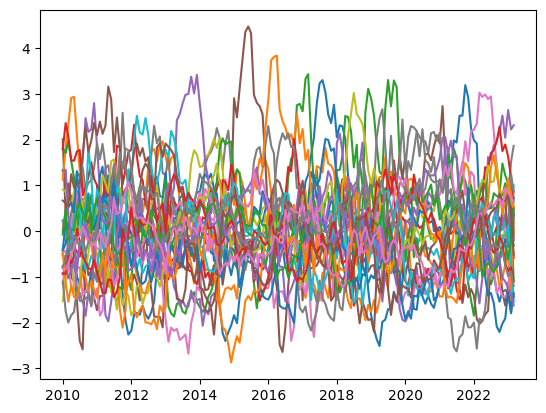

In [121]:
df = df_momentum_standarized
df.index = df.index.to_timestamp()
plt.plot(df)
plt.show()

Standarized Trend

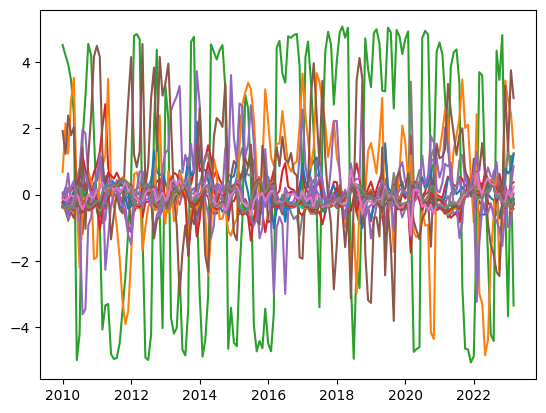

In [122]:
df = df_trend_standarized
df.index = df.index.to_timestamp()
plt.plot(df)
plt.show()

Standarized Value

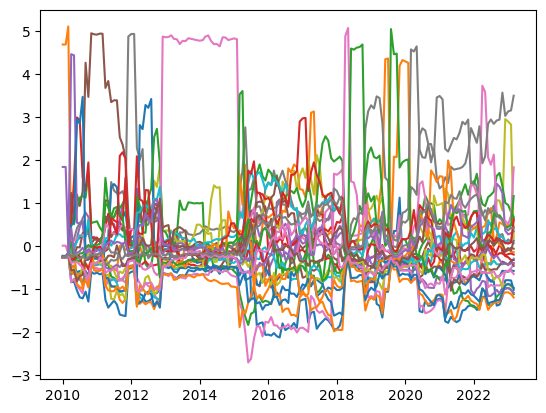

In [123]:
df = df_value_standarized
df.index = df.index.to_timestamp()
plt.plot(df)
plt.show()

Standarized Quality

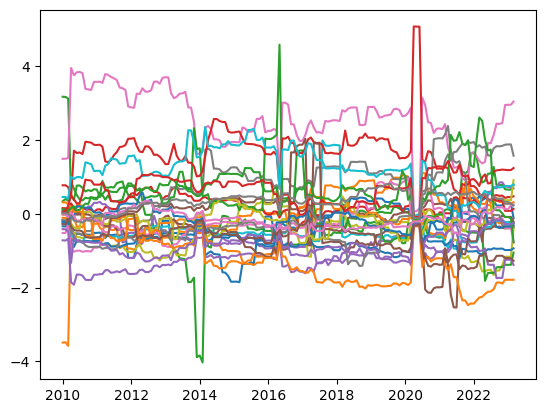

In [124]:
df = df_quality_standarized
df.index = df.index.to_timestamp()
plt.plot(df)
plt.show()

# Optimization & Performance for Full Characterstics

Right now, we have those 4 characterstics:

1. Momentum: df_momentum_standarized
2. Trend: df_trend_standarized
3. Value: df_value_standarized
4. Quality: df_quality_standarized



In [125]:
#df_momentum_standarized
#df_trend_standarized
#df_value_standarized
#df_quality_standarized

## Statistical Estimation of Expected Utility at the next time period

In [126]:
def get_port_utility(theta, w_bar, Nt, momentum, trend, value, quality, monthly_returns, gamma):
  ''' 
  Return the statistical estimation of the expectation of next period's
  the portfolio return's utility.
  
  Utility function being used is the CRRA: u(r_{p, t+1}) = 1/(1-gamma) * (1+r_{p, t+1})^(1-gamma)
  '''
  # Check dimensioniality 
  if not (momentum.shape == trend.shape == value.shape == quality.shape == monthly_returns.shape):
    raise ValueError('Dimension Error for the inputs')

  # First, take the transpose of historical indexes' characterstics
  # so row_i is the historical characterstic's of index i

  t_momentum = momentum.T.values
  t_trend    = trend.T.values
  t_value    = value.T 
  t_quality  = quality.T

  #print(f'''t_momentum is: 
  #{t_momentum}
  #''')
  #print(f'''t_trend is: 
  #{t_trend}
  #''')

  # Second, compute a matrix of theta.T @ characterstic
  # so row_i is the historical theta.T @ characterstic of index i
  # To achieve that, we compute: [theta1 * t_momentum + theta2 * t_trend]
  theta_chara = theta[0] * t_momentum + theta[1] * t_trend + theta[2] * t_value + theta[3] * t_quality 
  
  #print(f'''theta_chara is: 
  #{theta_chara}
  #''')

  # Third, we compute a matrix of weight_{i,t}
  # so row_i is the historical weight for index i
  w_it = w_bar + (1/Nt) * theta_chara

  #print(f'''w_it is: 
  #{w_it}
  #''')

  # Forth, we compute a matrix of w_it * NEXT PERIOD return
  # Since we have a matrix of weight_{i,t} where
  # row_i is the historical weight for index i
  # We need to perform elementwise multiplication with the NEXT PERIOD return
  # where the matrix of NEXT PERIOD return has:
  # row_i being the historical NEXT PERIOD return of index i
  t_month_rtn = monthly_returns.T.values
  rtn_it = w_it * t_month_rtn

  #print(f'''t_month_rtn is: 
  #{t_month_rtn}
  #''')

  #print(f'''rtn_it is: 
  #{rtn_it}
  #''')

  # Fifth, we aggragate by each column to get the portfolio return: r_{p, t+1}
  # One vector being the historical portfolio return
  port_trn_t = rtn_it.sum(axis = 0)

  #print(f'''port_trn_t is: 
  #{port_trn_t}
  #Type is: {type(port_trn_t)}
  #''')

  # Sixth, we compute the utility of the port_trn_t
  #u(r_{p, t+1}) = 1/(1-gamma) * (1+r_{p, t+1})^(1-gamma)


  #utility_t = 1/(1-gamma) * ((1+port_trn_t)**(1-gamma))
  if gamma == 1:
    utility_t = np.log(1+port_trn_t)
  else:
    utility_t = 1/(1-gamma) * ((1+port_trn_t)**(1-gamma))

  #print(f'''utility_t is: 
  #{utility_t}
  #''')

  # Finally, we estimate the expectation by taking the mean
  estimated_port_utility = utility_t.mean()

  #print(f'''estimated_port_utility is: 
  #{estimated_port_utility}
  #''')

  return estimated_port_utility

def neg_get_port_utility(theta, *args):
    return -get_port_utility(theta, *args)  

######################################################################

def get_port_utility_with_penalty(theta, w_bar, Nt, momentum, trend, value, quality, monthly_returns, gamma, penalty_multiplier = 0.001):
    port_utility = get_port_utility(theta, w_bar, Nt, momentum, trend, value, quality, monthly_returns, gamma)
    
    # Compute the matrix of weights
    t_momentum = momentum.T.values
    t_trend = trend.T.values
    t_value = value.T 
    t_quality = quality.T
    theta_chara = theta[0] * t_momentum + theta[1] * t_trend + theta[2] * t_value + theta[3] * t_quality 
    w_it = w_bar + (1/Nt) * theta_chara

    # Calculate the sum of negative weights in each row
    negative_weights_sum = (w_it * (w_it < 0)).sum(axis=1)
    
#    print(negative_weights_sum)
    # Calculate the penalty term
    penalty = penalty_multiplier * negative_weights_sum.sum()

    # Add the penalty term to the negative of the portfolio utility
    return -(port_utility - penalty)

def neg_get_port_utility_with_penalty(theta, *args):
    return -get_port_utility_with_penalty(theta, *args)



######################################################################




#get_port_utility([10, 1, 1, 4], w_bar, Nt, momentum, trend, value, quality, monthly_returns, gamma)
#get_port_utility_with_penalty([10, 1, 1, 4], w_bar, Nt, momentum, trend, value, quality, monthly_returns, gamma, penalty_multiplier = 0.01)

Inside the for loop:

  - i = 0:

    - 2010-01-01 ~ 2018-03-01 Momentum
    - 2010-01-01 ~ 2018-03-01 Trend
    - 2010-01-31 ~ 2018-03-31 Monthly Return

  - i = 59:

    - 2010-01-01 ~ 2023-02-01 Momentum
    - 2010-01-01 ~ 2023-02-01 Trend
    - 2010-01-31 ~ 2023-02-28 Monthly Return

## Optimization

In [127]:
#print(df_trend_standarized.shape)
#print(df_momentum_standarized.shape)
#print(df_monthly_rtn.shape)

start_date = '2017-06-01'

date_range = pd.date_range(start=start_date, end='2023-03-01', freq='MS')
df_theta = pd.DataFrame(index=date_range, columns=['theta_1', 'theta_2', 'theta_3', 'theta_4'], dtype=np.float64)
df_weights =  pd.DataFrame(index=date_range,
                           columns=[f'w_{index_name[:-6]}' for index_name in
                                    df_momentum_standarized.columns],
                            dtype=np.float64)


# Loop the function in 60 expending windows

expending_window = 70
time_length = df_momentum_standarized.shape[0]

# Number of observations we used for the first observation
time_length - expending_window

for i in range(expending_window):
  # Define initial guess for theta, and other inputs to the function
  initial_theta = np.array([-2, 0, 0, 0])
  w_bar = 1/len(df_momentum_standarized.columns)
  Nt = len(df_momentum_standarized.columns)
  #i=0
  momentum = df_momentum_standarized.iloc[:(time_length - expending_window) + i, :]
  trend = df_trend_standarized.iloc[:(time_length - expending_window) + i, :]
  value = df_value_standarized.iloc[:(time_length - expending_window) + i, :]
  quality = df_quality_standarized.iloc[:(time_length - expending_window) + i, :]
  monthly_returns = df_monthly_rtn.iloc[:(time_length - expending_window) + i, :]

  #87
  #momentum = df_momentum_standarized.iloc[i+90:(time_length - 60) + i, :]
  #trend = df_trend_standarized.iloc[i+90:(time_length - 60) + i, :]
  #monthly_returns = df_monthly_rtn.iloc[i+90:(time_length - 60) + i, :]

  gamma = 5

  # Use the minimize() function with BFGS method
  result = minimize(neg_get_port_utility, initial_theta,
                    args=(w_bar, Nt, momentum, trend, value, quality, monthly_returns, gamma),
                    method='BFGS')

  # Extract the optimal theta values from the result for each month
  optimal_theta = result.x
  df_theta.iloc[i, :] = optimal_theta


  # Compute the weights
  momentum_t = df_momentum_standarized.iloc[(time_length - expending_window) + i, :]
  trend_t    = df_trend_standarized.iloc[(time_length - expending_window) + i, :]
  value_t    = df_value_standarized.iloc[(time_length - expending_window) + i, :]
  quality_t  = df_quality_standarized.iloc[(time_length - expending_window) + i, :]
  optimal_weight = w_bar + (1/Nt)* (optimal_theta[0]*momentum_t + optimal_theta[1]*trend_t + optimal_theta[2]*value_t + optimal_theta[3]*quality_t) 
  #optimal_weight.sum()
  #optimal_weight.shape
  df_weights.iloc[i, :] = optimal_weight
  #df_weights.tail(1)
  

## Cumulative Return

So, we have computed the $\theta$ needed to compute the weights for those corresponding dates. i.e. the $\theta$ on 2018-04-01 corresponds to the weight needed to be held on 2018-04-01 till 2018-04-31.

Similarly for weights.

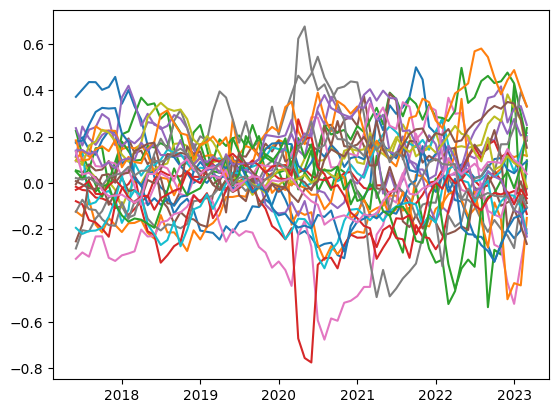

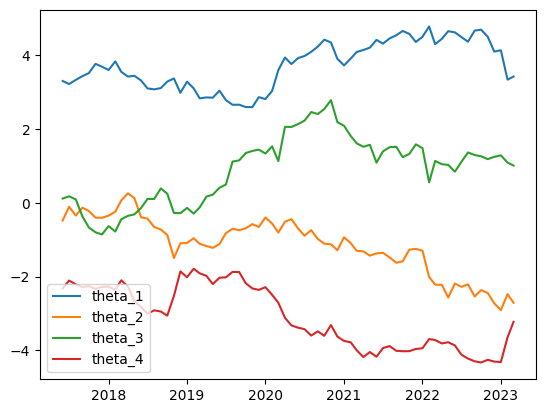

In [128]:
df_weights.head()
#df_weights.sum(axis = 1)

plt.plot(df_weights)
plt.show()

for column in df_theta.columns:
    plt.plot(df_theta[column], label=column)

plt.legend()
plt.show()

Now, we can compute the portfolio return to see the performance!!

In [129]:
df_port_mon_rtn = (df_monthly_rtn[df_monthly_rtn.index >= start_date] * df_weights.values).sum(axis = 1)
df_port_cum_rtn = (1 + df_port_mon_rtn).cumprod() - 1

print(f'''
The statistics are:
{df_port_mon_rtn.describe()}

The Volatility adjusted mean return is:
{round(df_port_mon_rtn.mean()/df_port_mon_rtn.std(), 5)}

The entire holding-period return from {df_port_cum_rtn.index[0]} to {df_port_cum_rtn.index[-1]} is:
{df_port_cum_rtn[-1]}

''')


The statistics are:
count    70.000000
mean      0.007076
std       0.046613
min      -0.126012
25%      -0.018524
50%       0.010835
75%       0.035038
max       0.141745
dtype: float64

The Volatility adjusted mean return is:
0.15181

The entire holding-period return from 2017-06-30 00:00:00 to 2023-03-31 00:00:00 is:
0.5205829165241456




Also, compute the equally weighted portfolio to compare the performance

In [130]:
df_ew_mon_rtn = df_monthly_rtn[df_monthly_rtn.index >= start_date].sum(axis = 1) * (1/Nt)
df_ew_cum_rtn = (1 + df_ew_mon_rtn).cumprod() - 1

we can plot it out:

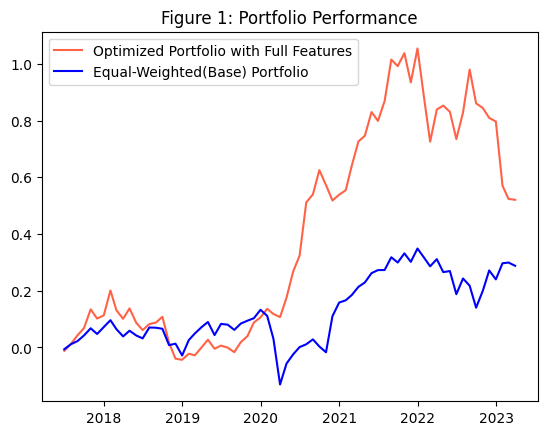

In [131]:
plt.plot(df_port_cum_rtn, label = 'Optimized Portfolio with Full Features', color = 'tomato')
plt.plot(df_ew_cum_rtn, label = 'Equal-Weighted(Base) Portfolio', color = 'blue')
plt.legend()
#plt.ylim(0.,1)
plt.title('Figure 1: Portfolio Performance')
plt.show()

# Optimization & Performance for 3 Characterstics

Right now, we will try 3 characterstics from the 4:

1. Momentum: df_momentum_standarized
2. Trend: df_trend_standarized
3. Value: df_value_standarized
4. Quality: df_quality_standarized



In [132]:
#df_momentum_standarized
#df_trend_standarized
#df_value_standarized
#df_quality_standarized

## Statistical Estimation of Expected Utility at the next time period

In [133]:
def get_port_utility(theta, w_bar, Nt, char_1, char_2, char_3, monthly_returns, gamma):
  ''' 
  Return the statistical estimation of the expectation of next period's
  the portfolio return's utility.
  
  Utility function being used is the CRRA: u(r_{p, t+1}) = 1/(1-gamma) * (1+r_{p, t+1})^(1-gamma)
  '''

  # Check dimensioniality 
  if not (char_1.shape == char_2.shape == char_3.shape == monthly_returns.shape):
    raise ValueError('Dimension Error for the inputs')

  t_char_1 = char_1.T.values
  t_char_2 = char_2.T.values
  t_char_3 = char_3.T 
  
  theta_chara = theta[0] * t_char_1 + theta[1] * t_char_2 + theta[2] * t_char_3 

  w_it = w_bar + (1/Nt) * theta_chara
  t_month_rtn = monthly_returns.T.values
  rtn_it = w_it * t_month_rtn
  port_trn_t = rtn_it.sum(axis = 0)
  if gamma == 1:
    utility_t = np.log(1+port_trn_t)
  else:
    utility_t = 1/(1-gamma) * ((1+port_trn_t)**(1-gamma))
  estimated_port_utility = utility_t.mean()

  return estimated_port_utility

def neg_get_port_utility(theta, *args):
    return -get_port_utility(theta, *args)  


## Optimizations

### Momentum, Trend, Value

In [134]:
#print(df_trend_standarized.shape)
#print(df_momentum_standarized.shape)
#print(df_monthly_rtn.shape)

start_date = '2017-06-01'

date_range = pd.date_range(start=start_date, end='2023-03-01', freq='MS')
df_theta = pd.DataFrame(index=date_range, columns=['theta_1', 'theta_2', 'theta_3'], dtype=np.float64)
df_weights =  pd.DataFrame(index=date_range,
                           columns=[f'w_{index_name[:-6]}' for index_name in
                                    df_momentum_standarized.columns],
                            dtype=np.float64)


# Loop the function in 60 expending windows

expending_window = 70
time_length = df_momentum_standarized.shape[0]

# Number of observations we used for the first observation
time_length - expending_window

for i in range(expending_window):
  # Define initial guess for theta, and other inputs to the function
  initial_theta = np.array([0, 0, 0])
  w_bar = 1/len(df_momentum_standarized.columns)
  Nt = len(df_momentum_standarized.columns)
  #i=0
  momentum = df_momentum_standarized.iloc[:(time_length - expending_window) + i, :]
  trend = df_trend_standarized.iloc[:(time_length - expending_window) + i, :]
  value = df_value_standarized.iloc[:(time_length - expending_window) + i, :]
  monthly_returns = df_monthly_rtn.iloc[:(time_length - expending_window) + i, :]

  #87
  #momentum = df_momentum_standarized.iloc[i+90:(time_length - 60) + i, :]
  #trend = df_trend_standarized.iloc[i+90:(time_length - 60) + i, :]
  #monthly_returns = df_monthly_rtn.iloc[i+90:(time_length - 60) + i, :]

  gamma = 5

  # Use the minimize() function with BFGS method
  result = minimize(neg_get_port_utility, initial_theta,
                    args=(w_bar, Nt, momentum, trend, value, monthly_returns, gamma),
                    method='BFGS')

  # Extract the optimal theta values from the result for each month
  optimal_theta = result.x
  df_theta.iloc[i, :] = optimal_theta


  # Compute the weights
  momentum_t = df_momentum_standarized.iloc[(time_length - expending_window) + i, :]
  trend_t    = df_trend_standarized.iloc[(time_length - expending_window) + i, :]
  value_t    = df_value_standarized.iloc[(time_length - expending_window) + i, :]
  
  optimal_weight = w_bar + (1/Nt)* (optimal_theta[0]*momentum_t + optimal_theta[1]*trend_t + optimal_theta[2]*value_t) 
  #optimal_weight.sum()
  #optimal_weight.shape
  df_weights.iloc[i, :] = optimal_weight
  #df_weights.tail(1)
  

#### Cumulative Return

So, we have computed the $\theta$ needed to compute the weights for those corresponding dates. i.e. the $\theta$ on 2018-04-01 corresponds to the weight needed to be held on 2018-04-01 till 2018-04-31.

Similarly for weights.

In [135]:
df_weights.head()
#df_weights.sum(axis = 1)

#plt.plot(df_weights)
#plt.show()

#plt.plot(df_theta)
#plt.show()

,w_MXAT,w_MXBE,w_IBOV,w_SPTSX,w_IPSA,w_SHSZ300,w_MXCZ,w_MXDK,w_MXFI,w_MXFR,...,w_OBX,w_MXPH,w_MXPL,w_MXPT,w_OMX,w_MXCH,w_TWSE,w_SET,w_UKX,w_SPX
2017-06-01,0.335694,-0.103647,0.182766,-0.023575,0.108321,-0.002759,-0.102210,-0.150641,0.053673,0.072902,...,0.045648,-0.069513,0.147699,0.042604,0.084544,-0.021697,0.053281,-0.009016,0.085234,0.029416
2017-07-01,0.361752,-0.118226,0.075906,-0.033687,0.054600,0.037718,-0.095067,-0.091087,0.044089,0.083358,...,0.033391,-0.098961,0.151745,-0.020004,0.075177,-0.005936,0.064572,-0.019852,0.005628,0.025394
2017-08-01,0.390222,-0.062113,0.051418,-0.038774,0.106408,0.069122,-0.104149,-0.097032,0.022090,0.067949,...,0.108532,-0.088653,0.209057,-0.022438,0.034226,0.021453,0.043497,-0.034516,0.009502,0.030987
2017-09-01,0.399897,-0.100664,0.119655,-0.042571,0.116790,0.042656,0.006220,-0.047188,-0.010099,0.074046,...,0.120680,-0.101257,0.277204,0.017416,0.011795,-0.034226,0.054869,-0.047748,-0.005063,0.008783
2017-10-01,0.372683,-0.130347,0.130892,-0.043388,0.153129,0.046250,0.006167,-0.020941,-0.055763,0.102585,...,0.163428,-0.094098,0.295099,0.034007,0.034670,-0.037988,0.004858,0.003349,-0.045056,-0.004731


Now, we can compute the portfolio return to see the performance!!

In [136]:
df_port_mon_rtn = (df_monthly_rtn[df_monthly_rtn.index >= start_date] * df_weights.values).sum(axis = 1)
df_port_cum_rtn = (1 + df_port_mon_rtn).cumprod() - 1
print(f'''
The statistics are:
{df_port_mon_rtn.describe()}

The Volatility adjusted mean return is:
{round(df_port_mon_rtn.mean()/df_port_mon_rtn.std(), 5)}

''')


The statistics are:
count    70.000000
mean      0.003666
std       0.038603
min      -0.082944
25%      -0.019764
50%       0.009586
75%       0.028542
max       0.097250
dtype: float64

The Volatility adjusted mean return is:
0.09496




Also, compute the equally weighted portfolio to compare the performance

In [137]:
df_ew_mon_rtn = df_monthly_rtn[df_monthly_rtn.index >= start_date].sum(axis = 1) * (1/Nt)
df_ew_cum_rtn = (1 + df_ew_mon_rtn).cumprod() - 1


we can plot it out:

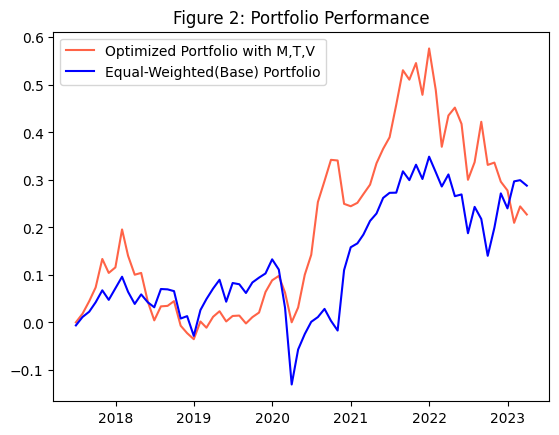

In [138]:
plt.plot(df_port_cum_rtn, label = 'Optimized Portfolio with M,T,V', color = 'tomato')
plt.plot(df_ew_cum_rtn, label = 'Equal-Weighted(Base) Portfolio', color = 'blue')
plt.legend()
#plt.ylim(0.,1)
plt.title('Figure 2: Portfolio Performance')
plt.show()

### Momentum, Trend, Quality

In [139]:
#print(df_trend_standarized.shape)
#print(df_momentum_standarized.shape)
#print(df_monthly_rtn.shape)

start_date = '2017-06-01'

date_range = pd.date_range(start=start_date, end='2023-03-01', freq='MS')
df_theta = pd.DataFrame(index=date_range, columns=['theta_1', 'theta_2', 'theta_3'], dtype=np.float64)
df_weights =  pd.DataFrame(index=date_range,
                           columns=[f'w_{index_name[:-6]}' for index_name in
                                    df_momentum_standarized.columns],
                            dtype=np.float64)


# Loop the function in 60 expending windows

expending_window = 70
time_length = df_momentum_standarized.shape[0]

# Number of observations we used for the first observation
time_length - expending_window

for i in range(expending_window):
  # Define initial guess for theta, and other inputs to the function
  initial_theta = np.array([0, 0, 0])
  w_bar = 1/len(df_momentum_standarized.columns)
  Nt = len(df_momentum_standarized.columns)
  #i=0
  momentum = df_momentum_standarized.iloc[:(time_length - expending_window) + i, :]
  trend = df_trend_standarized.iloc[:(time_length - expending_window) + i, :]
  quality = df_quality_standarized.iloc[:(time_length - expending_window) + i, :]
  monthly_returns = df_monthly_rtn.iloc[:(time_length - expending_window) + i, :]

  #87
  #momentum = df_momentum_standarized.iloc[i+90:(time_length - 60) + i, :]
  #trend = df_trend_standarized.iloc[i+90:(time_length - 60) + i, :]
  #monthly_returns = df_monthly_rtn.iloc[i+90:(time_length - 60) + i, :]

  gamma = 5

  # Use the minimize() function with BFGS method
  result = minimize(neg_get_port_utility, initial_theta,
                    args=(w_bar, Nt, momentum, trend, quality, monthly_returns, gamma),
                    method='BFGS')

  # Extract the optimal theta values from the result for each month
  optimal_theta = result.x
  df_theta.iloc[i, :] = optimal_theta


  # Compute the weights
  momentum_t = df_momentum_standarized.iloc[(time_length - expending_window) + i, :]
  trend_t    = df_trend_standarized.iloc[(time_length - expending_window) + i, :]
  quality_t  = df_quality_standarized.iloc[(time_length - expending_window) + i, :]
  optimal_weight = w_bar + (1/Nt)* (optimal_theta[0]*momentum_t + optimal_theta[1]*trend_t + optimal_theta[2]*quality_t) 
  #optimal_weight.sum()
  #optimal_weight.shape
  df_weights.iloc[i, :] = optimal_weight
  #df_weights.tail(1)
  

#### Cumulative Return

So, we have computed the $\theta$ needed to compute the weights for those corresponding dates. i.e. the $\theta$ on 2018-04-01 corresponds to the weight needed to be held on 2018-04-01 till 2018-04-31.

Similarly for weights.

In [140]:
df_weights.head()
#df_weights.sum(axis = 1)

#plt.plot(df_weights)
#plt.show()

#plt.plot(df_theta)
#plt.show()

,w_MXAT,w_MXBE,w_IBOV,w_SPTSX,w_IPSA,w_SHSZ300,w_MXCZ,w_MXDK,w_MXFI,w_MXFR,...,w_OBX,w_MXPH,w_MXPL,w_MXPT,w_OMX,w_MXCH,w_TWSE,w_SET,w_UKX,w_SPX
2017-06-01,0.383982,-0.126833,0.231777,-0.019407,0.234415,-0.002628,-0.319283,-0.286925,0.103266,0.139195,...,0.100542,-0.196316,0.185185,0.187707,0.057646,-0.035824,0.137475,0.009859,0.134976,0.018545
2017-07-01,0.420300,-0.149613,0.134751,-0.034772,0.159050,0.044248,-0.288855,-0.208939,0.077103,0.145719,...,0.082450,-0.225227,0.191255,0.102435,0.049553,-0.024246,0.138126,-0.005250,0.035458,0.009645
2017-08-01,0.445706,-0.076292,0.059591,-0.034969,0.227734,0.081683,-0.311543,-0.211008,0.050986,-0.087010,...,0.165024,-0.209684,0.255840,0.104028,-0.006189,0.005305,0.121419,-0.021391,0.043954,0.022200
2017-09-01,0.409517,-0.175818,0.145918,-0.065851,0.247914,0.053804,-0.252277,-0.144986,0.038976,-0.094198,...,0.169684,-0.191211,0.289899,0.132388,-0.046404,-0.031788,0.136867,-0.025453,0.019952,0.013769
2017-10-01,0.353435,-0.204033,0.153262,-0.071517,0.310935,0.057947,-0.271318,-0.107912,0.001335,-0.067115,...,0.213943,-0.167346,0.288804,0.136748,-0.025201,-0.020084,0.075396,0.035037,-0.029413,0.011230


Now, we can compute the portfolio return to see the performance!!

In [141]:
df_port_mon_rtn = (df_monthly_rtn[df_monthly_rtn.index >= start_date] * df_weights.values).sum(axis = 1)
df_port_cum_rtn = (1 + df_port_mon_rtn).cumprod() - 1
print(f'''
The statistics are:
{df_port_mon_rtn.describe()}

The Volatility adjusted mean return is:
{round(df_port_mon_rtn.mean()/df_port_mon_rtn.std(), 5)}

''')


The statistics are:
count    70.000000
mean      0.007780
std       0.045952
min      -0.118407
25%      -0.023373
50%       0.016285
75%       0.032314
max       0.109334
dtype: float64

The Volatility adjusted mean return is:
0.16931




Also, compute the equally weighted portfolio to compare the performance

In [142]:
df_ew_mon_rtn = df_monthly_rtn[df_monthly_rtn.index >= start_date].sum(axis = 1) * (1/Nt)
df_ew_cum_rtn = (1 + df_ew_mon_rtn).cumprod() - 1

we can plot it out:

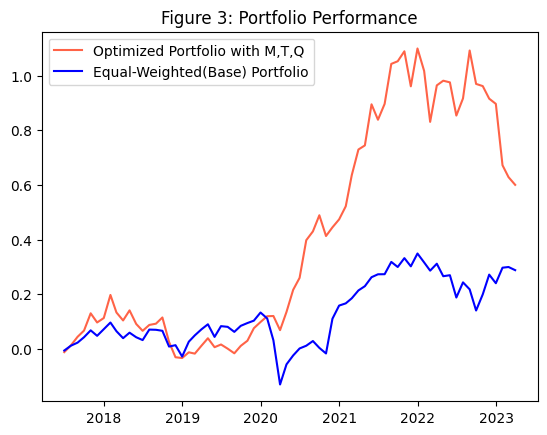

In [143]:
plt.plot(df_port_cum_rtn, label = 'Optimized Portfolio with M,T,Q', color = 'tomato')
plt.plot(df_ew_cum_rtn, label = 'Equal-Weighted(Base) Portfolio', color = 'blue')
plt.legend()
#plt.ylim(0.,1)
plt.title('Figure 3: Portfolio Performance')
plt.show()

### Momentum, Value, Quality

In [144]:
#print(df_trend_standarized.shape)
#print(df_momentum_standarized.shape)
#print(df_monthly_rtn.shape)

start_date = '2017-06-01'

date_range = pd.date_range(start=start_date, end='2023-03-01', freq='MS')
df_theta = pd.DataFrame(index=date_range, columns=['theta_1', 'theta_2', 'theta_3'], dtype=np.float64)
df_weights =  pd.DataFrame(index=date_range,
                           columns=[f'w_{index_name[:-6]}' for index_name in
                                    df_momentum_standarized.columns],
                            dtype=np.float64)


# Loop the function in 60 expending windows

expending_window = 70
time_length = df_momentum_standarized.shape[0]

# Number of observations we used for the first observation
time_length - expending_window

for i in range(expending_window):
  # Define initial guess for theta, and other inputs to the function
  initial_theta = np.array([0, 0, 0])
  w_bar = 1/len(df_momentum_standarized.columns)
  Nt = len(df_momentum_standarized.columns)
  #i=0
  momentum = df_momentum_standarized.iloc[:(time_length - expending_window) + i, :]
  value = df_value_standarized.iloc[:(time_length - expending_window) + i, :]
  quality = df_quality_standarized.iloc[:(time_length - expending_window) + i, :]
  monthly_returns = df_monthly_rtn.iloc[:(time_length - expending_window) + i, :]

  #87
  #momentum = df_momentum_standarized.iloc[i+90:(time_length - 60) + i, :]
  #trend = df_trend_standarized.iloc[i+90:(time_length - 60) + i, :]
  #monthly_returns = df_monthly_rtn.iloc[i+90:(time_length - 60) + i, :]

  gamma = 5

  # Use the minimize() function with BFGS method
  result = minimize(neg_get_port_utility, initial_theta,
                    args=(w_bar, Nt, momentum, value, quality, monthly_returns, gamma),
                    method='BFGS')

  # Extract the optimal theta values from the result for each month
  optimal_theta = result.x
  df_theta.iloc[i, :] = optimal_theta


  # Compute the weights
  momentum_t = df_momentum_standarized.iloc[(time_length - expending_window) + i, :]
  value_t    = df_value_standarized.iloc[(time_length - expending_window) + i, :]
  quality_t  = df_quality_standarized.iloc[(time_length - expending_window) + i, :]
  optimal_weight = w_bar + (1/Nt)* (optimal_theta[0]*momentum_t + optimal_theta[1]*value_t + optimal_theta[2]*quality_t) 
  #optimal_weight.sum()
  #optimal_weight.shape
  df_weights.iloc[i, :] = optimal_weight
  #df_weights.tail(1)
  

#### Cumulative Return

So, we have computed the $\theta$ needed to compute the weights for those corresponding dates. i.e. the $\theta$ on 2018-04-01 corresponds to the weight needed to be held on 2018-04-01 till 2018-04-31.

Similarly for weights.

In [145]:
df_weights.head()
#df_weights.sum(axis = 1)

#plt.plot(df_weights)
#plt.show()

#plt.plot(df_theta)
#plt.show()

,w_MXAT,w_MXBE,w_IBOV,w_SPTSX,w_IPSA,w_SHSZ300,w_MXCZ,w_MXDK,w_MXFI,w_MXFR,...,w_OBX,w_MXPH,w_MXPL,w_MXPT,w_OMX,w_MXCH,w_TWSE,w_SET,w_UKX,w_SPX
2017-06-01,0.348623,-0.124682,0.209448,-0.023418,0.231721,-0.011955,-0.323432,-0.259774,0.099838,0.123936,...,0.086815,-0.191453,0.167771,0.169842,0.046531,-0.033273,0.140592,0.000514,0.131974,0.015615
2017-07-01,0.405734,-0.145445,0.110246,-0.033580,0.159196,0.042808,-0.293308,-0.201065,0.082724,0.141007,...,0.078009,-0.219798,0.183885,0.096767,0.046183,-0.018733,0.142157,-0.006778,0.036148,0.012604
2017-08-01,0.421568,-0.077091,0.080431,-0.043041,0.224292,0.078519,-0.311934,-0.202437,0.046586,-0.093913,...,0.154073,-0.206513,0.241563,0.096275,-0.013713,0.002241,0.125631,-0.025384,0.039438,0.019656
2017-09-01,0.433379,-0.179243,0.169600,-0.063314,0.236525,0.053033,-0.224212,-0.153106,0.019020,-0.080483,...,0.177679,-0.205859,0.305383,0.143840,-0.035620,-0.050063,0.132729,-0.026790,0.017132,-0.001876
2017-10-01,0.396853,-0.212150,0.189453,-0.065798,0.292326,0.056536,-0.226589,-0.121934,-0.031786,-0.047425,...,0.225953,-0.194607,0.319758,0.158280,-0.009761,-0.052017,0.072176,0.031827,-0.031438,-0.015423


Now, we can compute the portfolio return to see the performance!!

In [146]:
df_port_mon_rtn = (df_monthly_rtn[df_monthly_rtn.index >= start_date] * df_weights.values).sum(axis = 1)
df_port_cum_rtn = (1 + df_port_mon_rtn).cumprod() - 1
print(f'''
The statistics are:
{df_port_mon_rtn.describe()}

The Volatility adjusted mean return is:
{round(df_port_mon_rtn.mean()/df_port_mon_rtn.std(), 5)}

''')


The statistics are:
count    70.000000
mean      0.005764
std       0.046916
min      -0.111187
25%      -0.026479
50%       0.011682
75%       0.035370
max       0.149864
dtype: float64

The Volatility adjusted mean return is:
0.12286




Also, compute the equally weighted portfolio to compare the performance

In [147]:
df_ew_mon_rtn = df_monthly_rtn[df_monthly_rtn.index >= start_date].sum(axis = 1) * (1/Nt)
df_ew_cum_rtn = (1 + df_ew_mon_rtn).cumprod() - 1

we can plot it out:

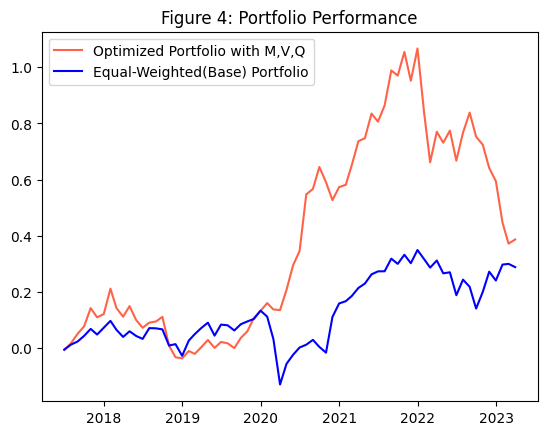

In [148]:
plt.plot(df_port_cum_rtn, label = 'Optimized Portfolio with M,V,Q', color = 'tomato')
plt.plot(df_ew_cum_rtn, label = 'Equal-Weighted(Base) Portfolio', color = 'blue')
plt.legend()
#plt.ylim(0.,1)
plt.title('Figure 4: Portfolio Performance')
plt.show()

### Trend, Value, Quality

Inside the for loop:

  - i = 0:

    - 2010-01-01 ~ 2018-03-01 Momentum
    - 2010-01-01 ~ 2018-03-01 Trend
    - 2010-01-31 ~ 2018-03-31 Monthly Return

  - i = 59:

    - 2010-01-01 ~ 2023-02-01 Momentum
    - 2010-01-01 ~ 2023-02-01 Trend
    - 2010-01-31 ~ 2023-02-28 Monthly Return

In [149]:
#print(df_trend_standarized.shape)
#print(df_momentum_standarized.shape)
#print(df_monthly_rtn.shape)

start_date = '2017-06-01'

date_range = pd.date_range(start=start_date, end='2023-03-01', freq='MS')
df_theta = pd.DataFrame(index=date_range, columns=['theta_1', 'theta_2', 'theta_3'], dtype=np.float64)
df_weights =  pd.DataFrame(index=date_range,
                           columns=[f'w_{index_name[:-6]}' for index_name in
                                    df_momentum_standarized.columns],
                            dtype=np.float64)


# Loop the function in 60 expending windows

expending_window = 70
time_length = df_momentum_standarized.shape[0]

# Number of observations we used for the first observation
time_length - expending_window

for i in range(expending_window):
  # Define initial guess for theta, and other inputs to the function
  initial_theta = np.array([0, 0, 0])
  w_bar = 1/len(df_momentum_standarized.columns)
  Nt = len(df_momentum_standarized.columns)
  #i=0
  trend = df_trend_standarized.iloc[:(time_length - expending_window) + i, :]
  value = df_value_standarized.iloc[:(time_length - expending_window) + i, :]
  quality = df_quality_standarized.iloc[:(time_length - expending_window) + i, :]
  monthly_returns = df_monthly_rtn.iloc[:(time_length - expending_window) + i, :]

  #87
  #momentum = df_momentum_standarized.iloc[i+90:(time_length - 60) + i, :]
  #trend = df_trend_standarized.iloc[i+90:(time_length - 60) + i, :]
  #monthly_returns = df_monthly_rtn.iloc[i+90:(time_length - 60) + i, :]

  gamma = 5

  # Use the minimize() function with BFGS method
  result = minimize(neg_get_port_utility, initial_theta,
                    args=(w_bar, Nt, trend, value, quality, monthly_returns, gamma),
                    method='BFGS')

  # Extract the optimal theta values from the result for each month
  optimal_theta = result.x
  df_theta.iloc[i, :] = optimal_theta


  # Compute the weights
  trend_t    = df_trend_standarized.iloc[(time_length - expending_window) + i, :]
  value_t    = df_value_standarized.iloc[(time_length - expending_window) + i, :]
  quality_t  = df_quality_standarized.iloc[(time_length - expending_window) + i, :]
  optimal_weight = w_bar + (1/Nt)* (optimal_theta[0]*trend_t + optimal_theta[1]*value_t + optimal_theta[2]*quality_t) 
  #optimal_weight.sum()
  #optimal_weight.shape
  df_weights.iloc[i, :] = optimal_weight
  #df_weights.tail(1)
  

#### Cumulative Return

So, we have computed the $\theta$ needed to compute the weights for those corresponding dates. i.e. the $\theta$ on 2018-04-01 corresponds to the weight needed to be held on 2018-04-01 till 2018-04-31.

Similarly for weights.

In [150]:
df_weights.head()
#df_weights.sum(axis = 1)

#plt.plot(df_weights)
#plt.show()

#plt.plot(df_theta)
#plt.show()

,w_MXAT,w_MXBE,w_IBOV,w_SPTSX,w_IPSA,w_SHSZ300,w_MXCZ,w_MXDK,w_MXFI,w_MXFR,...,w_OBX,w_MXPH,w_MXPL,w_MXPT,w_OMX,w_MXCH,w_TWSE,w_SET,w_UKX,w_SPX
2017-06-01,-0.037263,0.038914,0.003110,0.041982,0.117961,0.006685,-0.138124,0.015316,0.093360,0.037445,...,0.029616,-0.021432,0.004711,0.072273,-0.011262,0.057354,0.101694,0.021231,0.065291,0.036797
2017-07-01,-0.029067,0.040773,-0.140576,0.037232,0.099054,0.028791,-0.119564,0.024756,0.095972,0.037003,...,0.029276,-0.004553,0.006724,0.061525,-0.004802,0.063318,0.115235,0.029000,0.057196,0.047223
2017-08-01,-0.029086,0.038364,0.090315,0.024098,0.112218,0.029032,-0.127431,-0.000938,0.060466,-0.098393,...,0.023146,-0.014971,0.005168,0.067456,-0.028527,0.037584,0.106229,0.023388,0.043381,0.040206
2017-09-01,0.001313,-0.013779,0.270260,0.002661,0.096700,0.033517,-0.117854,-0.022133,0.044410,-0.076583,...,0.043282,-0.024430,0.014771,0.089989,-0.011612,0.020711,0.077166,0.038948,0.036059,0.020799
2017-10-01,0.021879,-0.012469,0.294386,0.022542,0.094293,0.032365,-0.092066,-0.026370,0.032827,-0.061599,...,0.052248,-0.030862,0.026863,0.099736,0.002661,0.010958,0.067416,0.042436,0.034629,0.013076


Now, we can compute the portfolio return to see the performance!!

In [151]:
df_port_mon_rtn = (df_monthly_rtn[df_monthly_rtn.index >= start_date] * df_weights.values).sum(axis = 1)
df_port_cum_rtn = (1 + df_port_mon_rtn).cumprod() - 1

print(f'''
The statistics are:
{df_port_mon_rtn.describe()}

The Volatility adjusted mean return is:
{round(df_port_mon_rtn.mean()/df_port_mon_rtn.std(), 5)}

''')


The statistics are:
count    70.000000
mean      0.004645
std       0.042390
min      -0.135539
25%      -0.016950
50%       0.006169
75%       0.027428
max       0.102484
dtype: float64

The Volatility adjusted mean return is:
0.10959




Also, compute the equally weighted portfolio to compare the performance

In [152]:
df_ew_mon_rtn = df_monthly_rtn[df_monthly_rtn.index >= start_date].sum(axis = 1) * (1/Nt)
df_ew_cum_rtn = (1 + df_ew_mon_rtn).cumprod() - 1

we can plot it out:

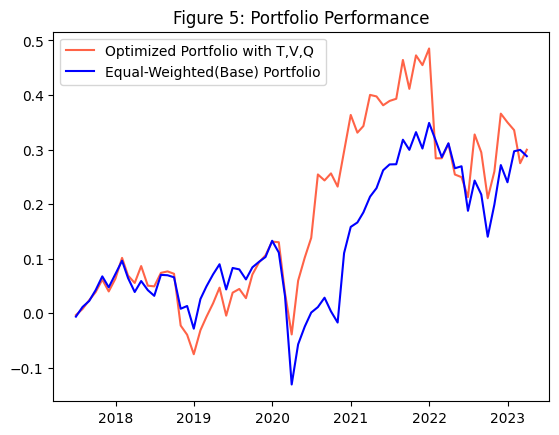

In [153]:
plt.plot(df_port_cum_rtn, label = 'Optimized Portfolio with T,V,Q', color = 'tomato')
plt.plot(df_ew_cum_rtn, label = 'Equal-Weighted(Base) Portfolio', color = 'blue')
plt.legend()
#plt.ylim(0.,1)
plt.title('Figure 5: Portfolio Performance')
plt.show()

# **Optimal Portfolio(Momentum, Trend, Quality)**

## Statistical Estimation of Expected Utility at the next time period

In [154]:
def get_port_utility(theta, w_bar, Nt, char_1, char_2, char_3, monthly_returns, gamma):
  ''' 
  Return the statistical estimation of the expectation of next period's
  the portfolio return's utility.
  
  Utility function being used is the CRRA: u(r_{p, t+1}) = 1/(1-gamma) * (1+r_{p, t+1})^(1-gamma)
  '''

  # Check dimensioniality 
  if not (char_1.shape == char_2.shape == char_3.shape == monthly_returns.shape):
    raise ValueError('Dimension Error for the inputs')

  t_char_1 = char_1.T.values
  t_char_2 = char_2.T.values
  t_char_3 = char_3.T 
  
  theta_chara = theta[0] * t_char_1 + theta[1] * t_char_2 + theta[2] * t_char_3 

  w_it = w_bar + (1/Nt) * theta_chara
  t_month_rtn = monthly_returns.T.values
  rtn_it = w_it * t_month_rtn
  port_trn_t = rtn_it.sum(axis = 0)
  if gamma == 1:
    utility_t = np.log(1+port_trn_t)
  else:
    utility_t = 1/(1-gamma) * ((1+port_trn_t)**(1-gamma))
  estimated_port_utility = utility_t.mean()

  return estimated_port_utility

def neg_get_port_utility(theta, *args):
    return -get_port_utility(theta, *args)  


## Optimization

In [155]:
#print(df_trend_standarized.shape)
#print(df_momentum_standarized.shape)
#print(df_monthly_rtn.shape)

start_date = '2017-06-01'

date_range = pd.date_range(start=start_date, end='2023-03-01', freq='MS')
df_theta = pd.DataFrame(index=date_range, columns=['theta_1', 'theta_2', 'theta_3'], dtype=np.float64)
df_weights =  pd.DataFrame(index=date_range,
                           columns=[f'w_{index_name[:-6]}' for index_name in
                                    df_momentum_standarized.columns],
                            dtype=np.float64)


# Loop the function in 60 expending windows

expending_window = 70
time_length = df_momentum_standarized.shape[0]

# Number of observations we used for the first observation
time_length - expending_window

for i in range(expending_window):
  # Define initial guess for theta, and other inputs to the function
  initial_theta = np.array([0, 0, 0])
  w_bar = 1/len(df_momentum_standarized.columns)
  Nt = len(df_momentum_standarized.columns)
  #i=0
  momentum = df_momentum_standarized.iloc[:(time_length - expending_window) + i, :]
  trend = df_trend_standarized.iloc[:(time_length - expending_window) + i, :]
  quality = df_quality_standarized.iloc[:(time_length - expending_window) + i, :]
  monthly_returns = df_monthly_rtn.iloc[:(time_length - expending_window) + i, :]

  #87
  #momentum = df_momentum_standarized.iloc[i+90:(time_length - 60) + i, :]
  #trend = df_trend_standarized.iloc[i+90:(time_length - 60) + i, :]
  #monthly_returns = df_monthly_rtn.iloc[i+90:(time_length - 60) + i, :]

  gamma = 5

  # Use the minimize() function with BFGS method
  result = minimize(neg_get_port_utility, initial_theta,
                    args=(w_bar, Nt, momentum, trend, quality, monthly_returns, gamma),
                    method='BFGS')

  # Extract the optimal theta values from the result for each month
  optimal_theta = result.x
  df_theta.iloc[i, :] = optimal_theta


  # Compute the weights
  momentum_t = df_momentum_standarized.iloc[(time_length - expending_window) + i, :]
  trend_t    = df_trend_standarized.iloc[(time_length - expending_window) + i, :]
  quality_t  = df_quality_standarized.iloc[(time_length - expending_window) + i, :]
  optimal_weight = w_bar + (1/Nt)* (optimal_theta[0]*momentum_t + optimal_theta[1]*trend_t + optimal_theta[2]*quality_t) 
  #optimal_weight.sum()
  #optimal_weight.shape
  df_weights.iloc[i, :] = optimal_weight
  #df_weights.tail(1)
  

## Cumulative Return

So, we have computed the $\theta$ needed to compute the weights for those corresponding dates. i.e. the $\theta$ on 2018-04-01 corresponds to the weight needed to be held on 2018-04-01 till 2018-04-31.

Similarly for weights.

In [156]:
df_weights.head()
#df_weights.sum(axis = 1)

#plt.plot(df_weights)
#plt.show()

#plt.plot(df_theta)
#plt.show()

,w_MXAT,w_MXBE,w_IBOV,w_SPTSX,w_IPSA,w_SHSZ300,w_MXCZ,w_MXDK,w_MXFI,w_MXFR,...,w_OBX,w_MXPH,w_MXPL,w_MXPT,w_OMX,w_MXCH,w_TWSE,w_SET,w_UKX,w_SPX
2017-06-01,0.383982,-0.126833,0.231777,-0.019407,0.234415,-0.002628,-0.319283,-0.286925,0.103266,0.139195,...,0.100542,-0.196316,0.185185,0.187707,0.057646,-0.035824,0.137475,0.009859,0.134976,0.018545
2017-07-01,0.420300,-0.149613,0.134751,-0.034772,0.159050,0.044248,-0.288855,-0.208939,0.077103,0.145719,...,0.082450,-0.225227,0.191255,0.102435,0.049553,-0.024246,0.138126,-0.005250,0.035458,0.009645
2017-08-01,0.445706,-0.076292,0.059591,-0.034969,0.227734,0.081683,-0.311543,-0.211008,0.050986,-0.087010,...,0.165024,-0.209684,0.255840,0.104028,-0.006189,0.005305,0.121419,-0.021391,0.043954,0.022200
2017-09-01,0.409517,-0.175818,0.145918,-0.065851,0.247914,0.053804,-0.252277,-0.144986,0.038976,-0.094198,...,0.169684,-0.191211,0.289899,0.132388,-0.046404,-0.031788,0.136867,-0.025453,0.019952,0.013769
2017-10-01,0.353435,-0.204033,0.153262,-0.071517,0.310935,0.057947,-0.271318,-0.107912,0.001335,-0.067115,...,0.213943,-0.167346,0.288804,0.136748,-0.025201,-0.020084,0.075396,0.035037,-0.029413,0.011230


Now, we can compute the portfolio return to see the performance!!

In [157]:
df_port_mon_rtn = (df_monthly_rtn[df_monthly_rtn.index >= start_date] * df_weights.values).sum(axis = 1)
df_port_cum_rtn = (1 + df_port_mon_rtn).cumprod() - 1
print(f'''
The statistics are:
{df_port_mon_rtn.describe()}

The Volatility adjusted mean return is:
{round(df_port_mon_rtn.mean()/df_port_mon_rtn.std(), 5)}

''')


The statistics are:
count    70.000000
mean      0.007780
std       0.045952
min      -0.118407
25%      -0.023373
50%       0.016285
75%       0.032314
max       0.109334
dtype: float64

The Volatility adjusted mean return is:
0.16931




Also, compute the equally weighted portfolio to compare the performance

In [158]:
df_ew_mon_rtn = df_monthly_rtn[df_monthly_rtn.index >= start_date].sum(axis = 1) * (1/Nt)
df_ew_cum_rtn = (1 + df_ew_mon_rtn).cumprod() - 1

we can plot it out:

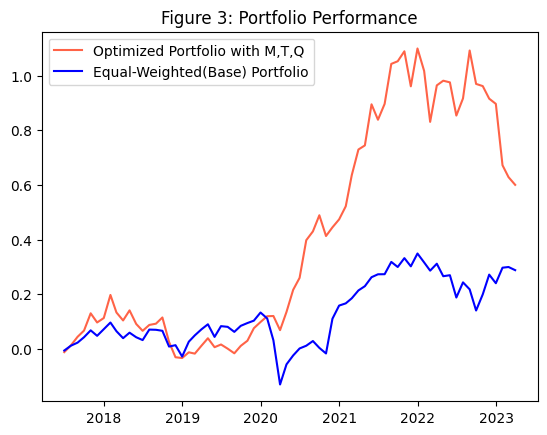

In [159]:
plt.plot(df_port_cum_rtn, label = 'Optimized Portfolio with M,T,Q', color = 'tomato')
plt.plot(df_ew_cum_rtn, label = 'Equal-Weighted(Base) Portfolio', color = 'blue')
plt.legend()
#plt.ylim(0.,1)
plt.title('Figure 3: Portfolio Performance')
plt.show()

## Risk Matrices

Define VaR, CVaR and Maximal Drawdown functions

In [160]:
class var_cvar:
    def __init__(self, hist_return, alpha, port_weight, cov_matrix, dof):
      '''initialize
      '''
      self.data = hist_return
      self.alpha = alpha # alpha = 5
      self.port_weight = port_weight
      self.cov_matrix = cov_matrix
      self.dof = dof
      self.port_std = (port_weight.T @ cov_matrix @ port_weight)**(0.5)
      self.port_hist_returns = hist_return @ port_weight

    def historicalVaR(self):
      return np.percentile(self.port_hist_returns, self.alpha)

    def historicalCVaR(self):
      return self.port_hist_returns[self.port_hist_returns <= self.historicalVaR()].mean()

    def distribution_var_cvar(self):
      # Prepare for thr test of t-distribution:
      # calculate the mean and standard deviation of the data
      
      #port_std = (self.port_weight.T @ self.cov_matrix @ self.port_weight)**(0.5)
      #port_hist_returns = self.data @ self.port_weight

      port_meanrtn = self.port_hist_returns.mean()
      port_stdrtn = self.port_hist_returns.std()

      # get the theoretical CDF of the t-distribution with the calculated mean and standard deviation
      t_dist = stats.t(df=len(self.data)-1, loc=port_meanrtn, scale=port_stdrtn)

      # perform the KS test on the data
      test_stat, p_val = stats.kstest(self.port_hist_returns, t_dist.cdf)

      # Test if it's normally distributed
      if shapiro(self.port_hist_returns)[1] > 0.05: # Normally distributed
        distribution = 'normal'
      # Test if it's t-distributed
      elif p_val > 0.05: # if p-val > 0.05, it's t-dist; if p-val < 0.05, others
        distribution = 't'
      else:
        distribution = 'undefined'
      return distribution

    def generate_var_cvar(self):
      '''generate and return a np.array (numpy array) containing a sequence 
      of stock values, corresponding to a random sequence of stock return.
      '''
      #port_std = (self.port_weight.T @ self.cov_matrix @ self.port_weight)**(0.5)
      #port_hist_returns = self.data @ self.port_weight
    
      stat, p = shapiro(self.port_hist_returns) 

      if self.distribution_var_cvar() == 'normal':
        VaR = norm.ppf(1-self.alpha/100)*self.port_std - self.port_hist_returns.mean()
        CVaR = (self.alpha/100)**-1 * norm.pdf(norm.ppf(self.alpha/100))*self.port_std - self.port_hist_returns.mean()
        return VaR, CVaR
#      elif self.distribution_var_cvar() == 't':
#        nu = self.dof
#        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-self.alpha/100, nu) * self.port_std - self.port_hist_returns.mean()
#        xanu = t.ppf(self.alpha/100, nu)
#        CVaR = -1/(self.alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * self.port_std - self.port_hist_returns.mean()
#        return -VaR, -CVaR
      else:
        return self.historicalVaR(), self.historicalCVaR()

    def maximun_drawdown(self):
      #port_std = (self.port_weight.T @ self.cov_matrix @ self.port_weight)**(0.5)
      #port_hist_returns = self.data @ self.port_weight
      cum_hist_return = (self.port_hist_returns).cumsum() 


      Roll_Max = self.port_hist_returns.cummax()
      Daily_Drawdown = self.port_hist_returns/Roll_Max - 1.0
      Max_Daily_Drawdown = Daily_Drawdown.cummin()

      # cum_hist_return.plot()
      Daily_Drawdown.plot()
      Max_Daily_Drawdown.plot()
      pp.show()
      return Daily_Drawdown, Max_Daily_Drawdown

In [161]:
# Change the weights from monthly df into daily df
date_range = pd.date_range(df_weights.index.min(), '2023-03-31', freq='D')
df_weights_daily = pd.DataFrame(index=date_range).join(df_weights)
df_weights_daily = df_weights_daily.ffill()
  
# Entire Historical Returns
df_daily_hist_rtn = df_daily_rtn[df_daily_rtn.index >= '2012-06-01']
df_daily_hist_rtn = df_daily_hist_rtn[common_columns]

# Create the VaR dataframe
df_VaR_daily = pd.DataFrame(index = df_weights_daily.index,
                            columns = [['PPP', 'EWP']])

# Create the CVaR dataframe
df_CVaR_daily = pd.DataFrame(index = df_weights_daily.index,
                            columns = [['PPP', 'EWP']])

# For everyday, we will compute the VaR using Using past 5 year return
before_5yrs = pd.DateOffset(months = 5*12)
before_1day = pd.DateOffset(days = 1)
df_VaR_daily.index[0] - before_5yrs
df_VaR_daily.index[0] - before_1day

for i in range(len(df_VaR_daily.index)):
  # When i = 0, the historical return is from 2012-06-01 to 2017-05-31
#  i = 0
  start_date = df_VaR_daily.index[i] - before_5yrs
  end_date   = df_VaR_daily.index[i] - before_1day
  historical_rtn =  df_daily_hist_rtn.loc[start_date: end_date, :]

#  historical_rtn.shape
  cov_matrix = historical_rtn.cov().values
#  cov_matrix.shape
  opti_weight = df_weights_daily.loc[df_VaR_daily.index[i], :].values.reshape(28, 1)
#  port_weight.shape
  opti_var_cvar = var_cvar(historical_rtn, 5, opti_weight, cov_matrix, 5*365)
  daily_var = opti_var_cvar.generate_var_cvar()[0] #Var
  daily_cvar = opti_var_cvar.generate_var_cvar()[1] #CVar
  df_VaR_daily.iloc[i, 0] = daily_var
  df_CVaR_daily.iloc[i, 0] = daily_cvar
  

  ew_weight = np.repeat(1/28, 28).reshape(28, 1)
#  ew_weight.shape
  ew_var_cvar = var_cvar(historical_rtn, 5, ew_weight, cov_matrix, 5*365)
  ew_daily_var = ew_var_cvar.generate_var_cvar()[0] #Var
  ew_daily_cvar = ew_var_cvar.generate_var_cvar()[1] #CVar
  df_VaR_daily.iloc[i, 1] = ew_daily_var
  df_CVaR_daily.iloc[i, 1] = ew_daily_cvar.values
  



IndexError: ignored

In [ ]:
for column in df_VaR_daily.columns:
  plt.plot(df_VaR_daily[column], label = column[0])
plt.legend()
plt.ylim(-0.04, -0)
plt.title('Daily VaR of Portfolios')
plt.show()

In [ ]:
for column in df_CVaR_daily.columns:
  plt.plot(df_CVaR_daily[column], label = column[0])
plt.legend()
plt.ylim(-0.04, -0)
plt.title('Daily CVaR of Portfolios')
plt.show()
